In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PneumoniaMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns

In [ ]:

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the training set
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)


Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz


In [ ]:
print("Number of training samples:", len(train_dataset))
sample_img, sample_label = train_dataset[102]
print("Sample image shape:", sample_img.shape)  # Usually (1, 28, 28) for grayscale images
print("Sample label:", sample_label)

Number of training samples: 4708
Sample image shape: torch.Size([1, 28, 28])
Sample label: [1]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from collections import Counter

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset   = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset  = PneumoniaMNIST(split='test', transform=transform, download=True)

Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz


In [ ]:

#   Split
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 4708
Validation set size: 524
Test set size: 624


In [ ]:
def count_labels(dataset):
    labels = [int(label) for _, label in dataset]
    counter = Counter(labels)
    print(f"Label counts: {counter}")
    print(f"Normal: {counter.get(0,0)}, Pneumonia: {counter.get(1,0)}\n")
    return labels

print("Training set labels:")
train_labels = count_labels(train_dataset)

print("Validation set labels:")
val_labels = count_labels(val_dataset)

print("Test set labels:")
test_labels = count_labels(test_dataset)

Training set labels:


C:\Users\Abeer\AppData\Local\Temp\ipykernel_6172\2288640812.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels = [int(label) for _, label in dataset]


Label counts: Counter({1: 3494, 0: 1214})
Normal: 1214, Pneumonia: 3494

Validation set labels:
Label counts: Counter({1: 389, 0: 135})
Normal: 135, Pneumonia: 389

Test set labels:
Label counts: Counter({1: 390, 0: 234})
Normal: 234, Pneumonia: 390



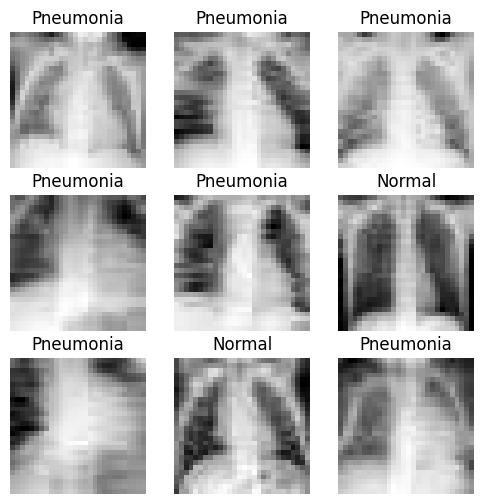

In [ ]:
# 3) Visualization Example

plt.figure(figsize=(6,6))
for i in range(9):
    image, label = train_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Pneumonia" if label==1 else "Normal")
    plt.axis('off')
plt.show()

In [ ]:
# 2) Data Preprocessing

# Augmentation + Normalization
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:

# 3) Load Dataset
train_dataset = PneumoniaMNIST(split='train', transform=transform_train, download=True)
val_dataset   = PneumoniaMNIST(split='val',   transform=transform_test, download=True)
test_dataset  = PneumoniaMNIST(split='test',  transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128)
test_loader  = DataLoader(test_dataset, batch_size=128)

Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Abeer\.medmnist\pneumoniamnist.npz


In [ ]:
# 4) CNN Model
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


model = PneumoniaCNN().to(device)

In [ ]:
# 5) Training Setup
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# Early stopping parameters
patience = 3  # how many epochs to wait after last improvement
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

for epoch in range(15):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1: Train Loss=0.5796, Val Loss=0.5202
Epoch 2: Train Loss=0.4619, Val Loss=0.3809
Epoch 3: Train Loss=0.3392, Val Loss=0.2749
Epoch 4: Train Loss=0.2469, Val Loss=0.2108
Epoch 5: Train Loss=0.2148, Val Loss=0.2025
Epoch 6: Train Loss=0.1957, Val Loss=0.2044
Epoch 7: Train Loss=0.2080, Val Loss=0.2066
Epoch 8: Train Loss=0.2092, Val Loss=0.1849
Epoch 9: Train Loss=0.1806, Val Loss=0.1791
Epoch 10: Train Loss=0.1921, Val Loss=0.1786
Epoch 11: Train Loss=0.1760, Val Loss=0.1863
Epoch 12: Train Loss=0.1717, Val Loss=0.1796
Epoch 13: Train Loss=0.1681, Val Loss=0.1723
Epoch 14: Train Loss=0.1667, Val Loss=0.1728
Epoch 15: Train Loss=0.1663, Val Loss=0.1676


In [ ]:
# 7) Evaluation on Test Set
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [ ]:
# 8) Metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)
auc  = roc_auc_score(all_labels, all_probs)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8814
Precision: 0.8575
Recall: 0.9718
F1-score: 0.9111
AUC: 0.9467


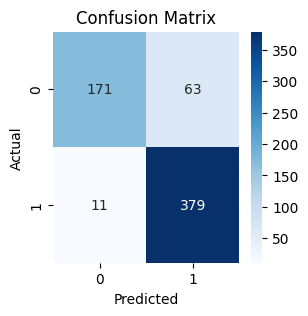

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

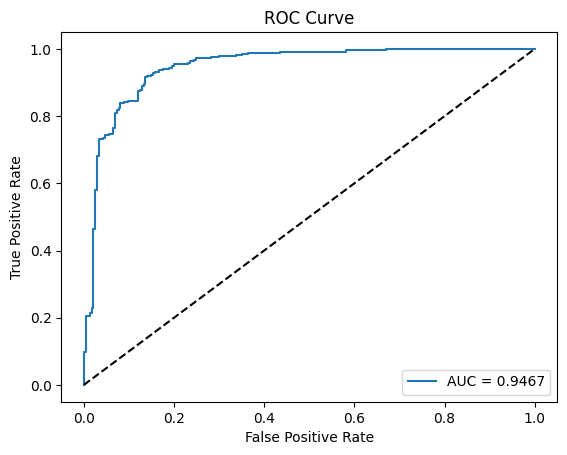

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

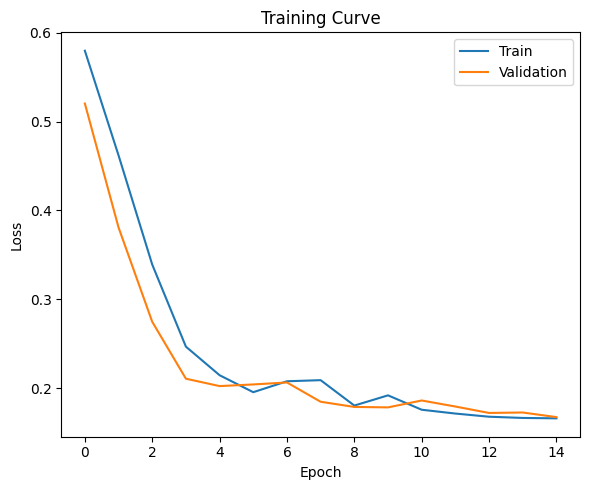

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()
plt.close()

In [ ]:
# Collect misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

for i, (image, label) in enumerate(test_dataset):
    prob = torch.sigmoid(model(image.unsqueeze(0).to(device))).item()
    pred = 1 if prob >= 0.5 else 0

    if pred != label:
        misclassified_images.append(image.squeeze().numpy())
        misclassified_labels.append(label)
        misclassified_preds.append(pred)

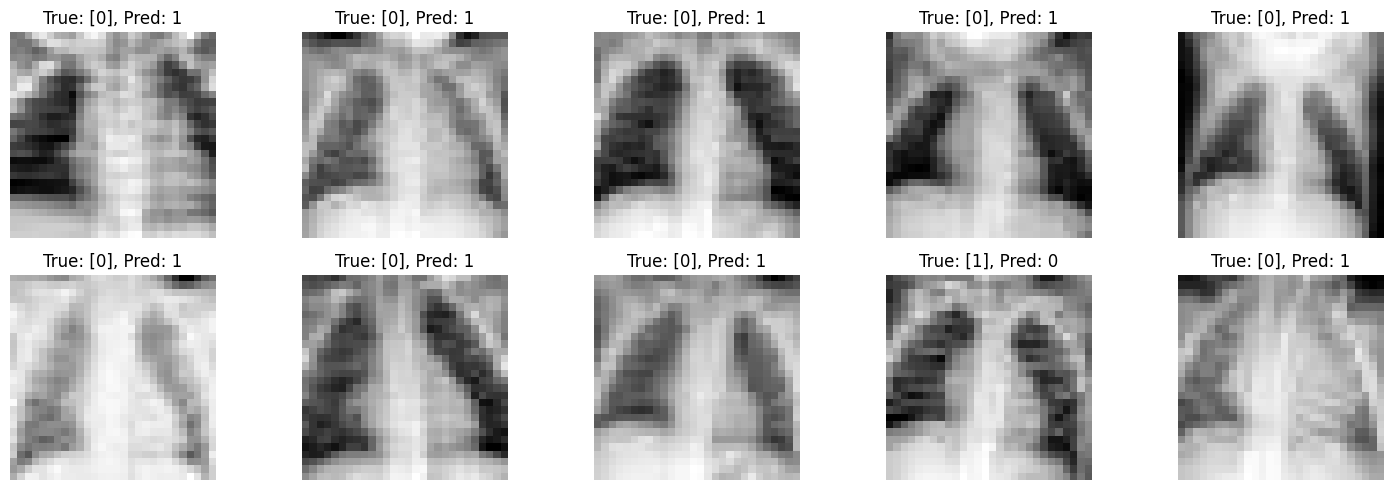

In [ ]:

# Show first 10 misclassified images
num_images = min(10, len(misclassified_images))
plt.figure(figsize=(15,5))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(misclassified_images[i], cmap='gray')
    plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()